<a href="https://colab.research.google.com/github/vijaygopisankar/project/blob/03_11-updated-code/project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting google drive with colab

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


giving the path to dataset

In [14]:
import os
#Defining the path to dataset in the drive
base_dir='/content/drive/MyDrive/zip datafiles/dataverse_files'

train_images_part1 = os.path.join(base_dir, 'HAM10000_images_part_1.zip')
train_images_part2 = os.path.join(base_dir, 'HAM10000_images_part_2.zip')
metadata_path = os.path.join(base_dir, 'HAM10000_metadata')

unzipping the files

In [15]:
import zipfile

# Unzipping part 1
with zipfile.ZipFile(train_images_part1, 'r') as zip_ref:
    zip_ref.extractall('/content/HAM10000/part1')

# Unzipping part 2
with zipfile.ZipFile(train_images_part2, 'r') as zip_ref:
    zip_ref.extractall('/content/HAM10000/part2')

reading the data and displaying first few rows

In [16]:
import pandas as pd

metadata_file = os.path.join(base_dir, 'HAM10000_metadata')
metadata = pd.read_csv(metadata_file)
metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,vidir_modern
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,vidir_modern


defining lable path and image path

In [17]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

#Image paths and labels from metadata
image_paths = metadata['image_id'].apply(lambda x: '/content/HAM10000/part1/' + x + '.jpg' if os.path.exists('/content/HAM10000/part1/' + x + '.jpg')
                                          else '/content/HAM10000/part2/' + x + '.jpg')

In [18]:
labels = metadata['dx']

# Encoding labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

Preprocessing images  to a uniform size

In [19]:
# Preprocessing images
IMG_SIZE = 128  # Resizing the images to 128x128

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.astype('float32') / 255.0  # Normalizing pixel values between 0 and 1
    return image

# Applying preprocessing to all images
images = np.array([preprocess_image(img_path) for img_path in image_paths])

spliting the data into training & testing part

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

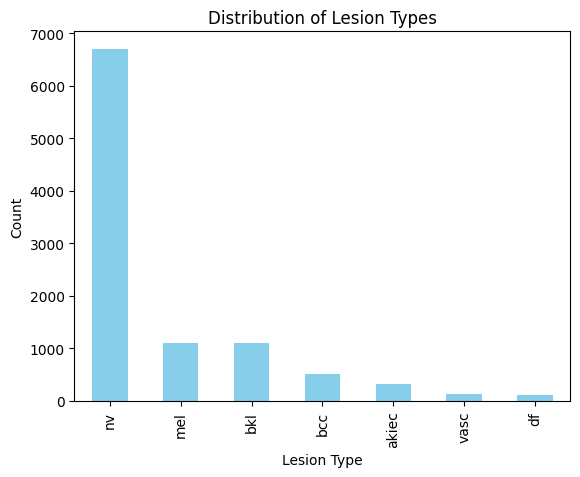

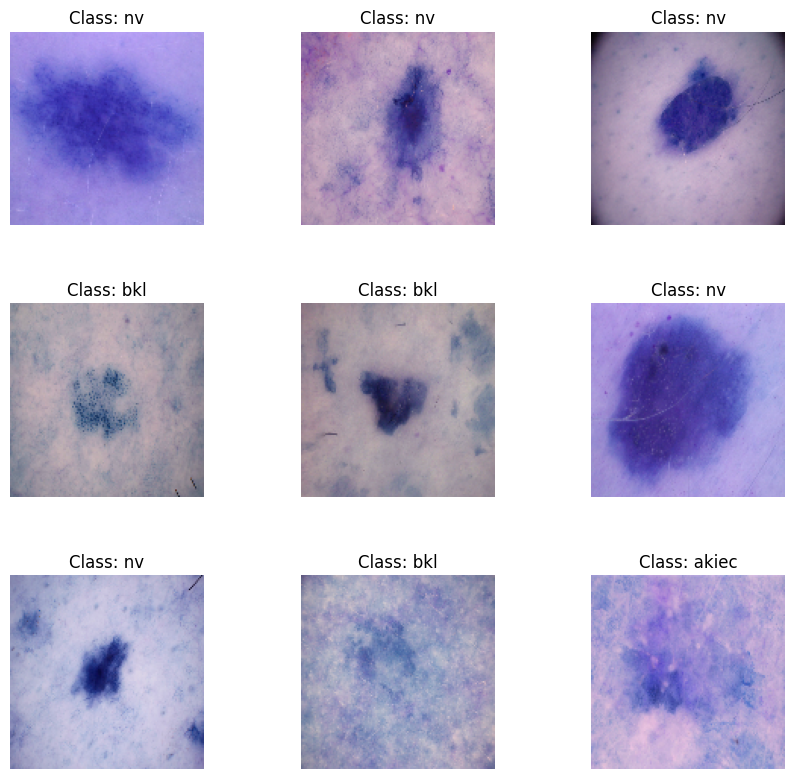

In [21]:
import matplotlib.pyplot as plt

# Plotting distribution of classes
metadata['dx'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Lesion Types')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.show()

# Displaying some sample images with labels
def plot_sample_images(X, y, label_encoder):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in np.arange(0, 9):
        axes[i].imshow(X[i])
        label = label_encoder.inverse_transform([np.argmax(y[i])])[0]
        axes[i].set_title(f"Class: {label}")
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()

plot_sample_images(X_train, y_train, label_encoder)

In [22]:
# Saving preprocessed arrays
np.save('/content/drive/My Drive/X_train.npy', X_train)
np.save('/content/drive/My Drive/y_train.npy', y_train)
np.save('/content/drive/My Drive/X_test.npy', X_test)
np.save('/content/drive/My Drive/y_test.npy', y_test)

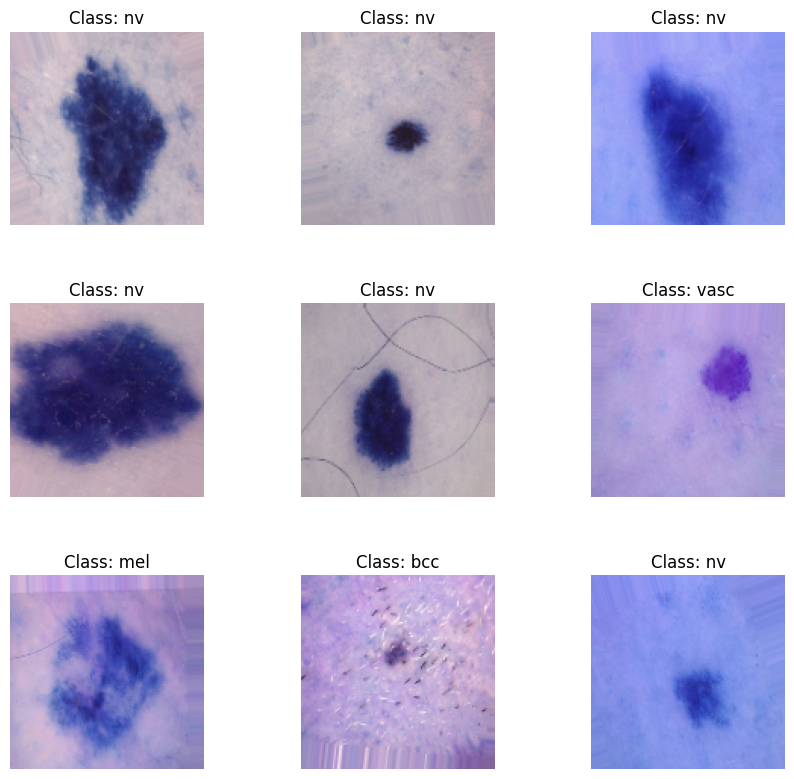

In [23]:
#Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to your training data
datagen.fit(X_train)

# Displaying some augmented images
augmented_images, augmented_labels = next(datagen.flow(X_train, y_train, batch_size=9))

plot_sample_images(augmented_images, augmented_labels, label_encoder)  # Reusing the plot function to visualize

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with classes from label encoder
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=10,
                    steps_per_epoch=len(X_train) // 32)

# Save the model after training
model.save('/content/drive/MyDrive/skin_lesion_cnn_model.h5')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.6498 - loss: 1.1487 - val_accuracy: 0.6685 - val_loss: 0.9290
Epoch 2/10
  1/250 ━━━━━━━━━━━━━━━━━━━━ 5:42 1s/step - accuracy: 0.7500 - loss: 0.7173

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.7500 - loss: 0.7173 - val_accuracy: 0.6685 - val_loss: 0.9222
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.6624 - loss: 0.9808 - val_accuracy: 0.6680 - val_loss: 0.9027
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.6250 - loss: 1.0195 - val_accuracy: 0.6680 - val_loss: 0.8914
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.6716 - loss: 0.9410 - val_accuracy: 0.6740 - val_loss: 0.8576
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.8125 - loss: 0.5905 - val_accuracy: 0.6745 - val_loss: 0.8643
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.6782 - loss: 0.8894 - val_accuracy: 0.6735 - val_loss: 0.8630
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.7812 - loss: 0.6708 - val_accuracy: 0.6735 - val_loss: 0.8575
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.6934 - loss: 0.8507 - val_accuracy: 

63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step
Classification Report:
               precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        69
         bcc       0.50      0.01      0.02        93
         bkl       0.35      0.05      0.08       228
          df       0.00      0.00      0.00        28
         mel       0.36      0.04      0.06       226
          nv       0.68      0.98      0.81      1338
        vasc       0.62      0.62      0.62        21

    accuracy                           0.67      2003
   macro avg       0.36      0.24      0.23      2003
weighted avg       0.57      0.67      0.56      2003



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


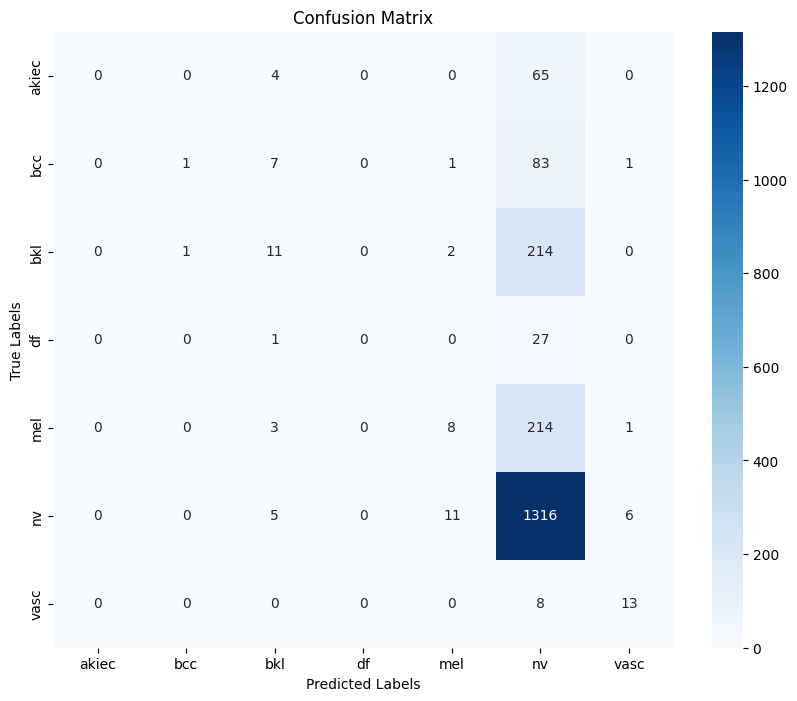

AUC-ROC Score: 0.8643480716418755


In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

# Load the saved model (if you want to ensure you're testing the right model)
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/skin_lesion_cnn_model.h5')

# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Calculate AUC-ROC score
try:
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    print("AUC-ROC Score:", auc)
except ValueError:
    print("AUC-ROC calculation requires binarized labels.")

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step


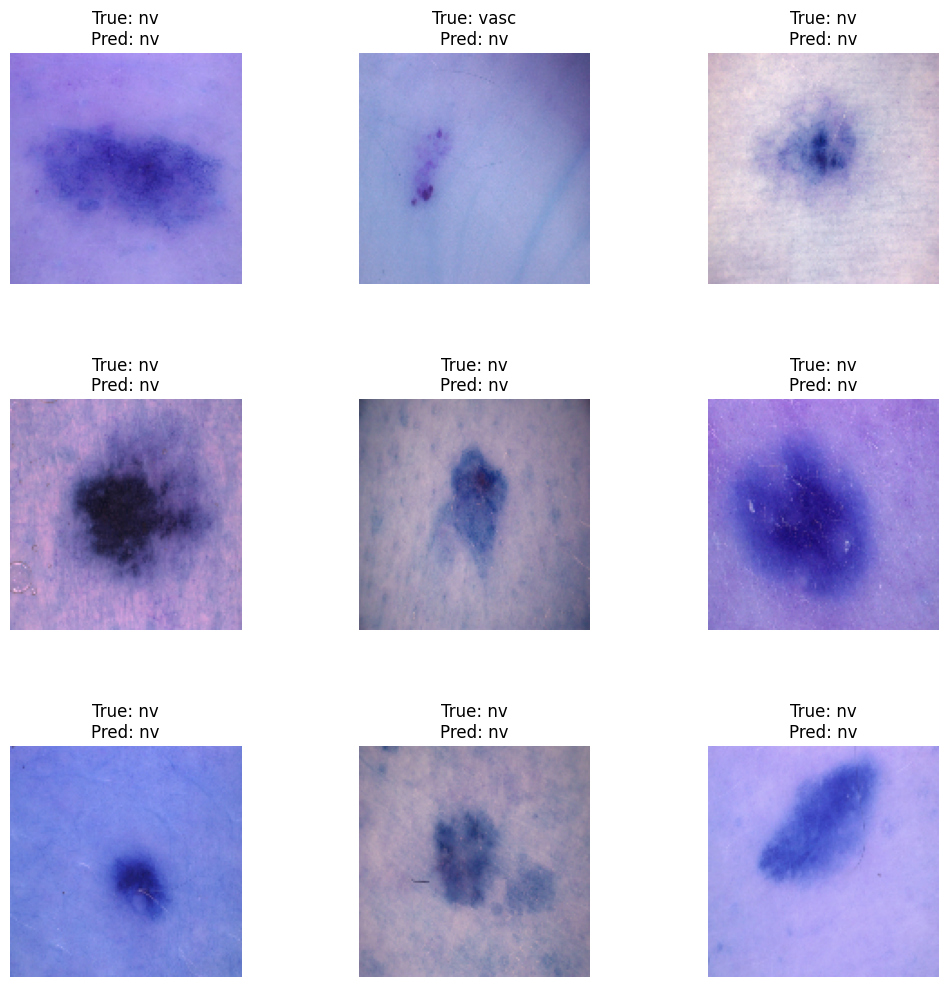

In [27]:
import random

# Function to display images with true and predicted labels
def display_predictions(X, y_true, y_pred, label_encoder, num_images=9):
    indices = random.sample(range(len(X)), num_images)
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        true_label = label_encoder.inverse_transform([np.argmax(y_true[idx])])[0]
        pred_label = label_encoder.inverse_transform([np.argmax(y_pred[idx])])[0]

        axes[i].imshow(X[idx])
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

# Predict labels for the test images
y_pred_prob = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Display test images with true and predicted labels
display_predictions(X_test, y_test, y_pred_prob, label_encoder)